In [1]:
from qiskit.quantum_info import Statevector, PauliList, DensityMatrix, SparsePauliOp
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator
import time
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt

# 710 HW1 GAN EXAMPLE

Below are sub-routines for visualization and utility, such as plotting a statevector of a single qubit on bloch sphere and replacing an element on an array etc.

note: _bloch_multivector_data function is taken from a qiskit sourcecode.

In [2]:
#taken from qiskit sourcecode
def _bloch_multivector_data(state):
    rho = DensityMatrix(state)
    num = rho.num_qubits
    if num is None:
        raise VisualizationError("Input is not a multi-qubit quantum state.")
    pauli_singles = PauliList(["X", "Y", "Z"])
    bloch_data = []
    for i in range(num):
        if num > 1:
            paulis = PauliList.from_symplectic(
                np.zeros((3, (num - 1)), dtype=bool), np.zeros((3, (num - 1)), dtype=bool)
            ).insert(i, pauli_singles, qubit=True)
        else:
            paulis = pauli_singles
        bloch_state = [np.real(np.trace(np.dot(mat, rho.data))) for mat in paulis.matrix_iter()]
        bloch_data.append(bloch_state)
    return bloch_data

#given a quantum circuit, returns the selected qubit's qubit's statevector
def statevector_qubit(qc, state_qubit):
    statevector = Statevector(qc)
    return _bloch_multivector_data(statevector)[state_qubit]
    
#replace an element and return list
def replace_element(list, index, new_value):
    return [new_value if i == index else x for i, x in enumerate(list)]
    

## circuit functions in order asked for in the assignment

In [3]:
repetitions = 3 #3 layer parameterized circuits

def real(qc, angles):
    #apply H & rotation to wire 0
    qc.h(0)
    qc.rx(angles[0], 0)
    qc.ry(angles[1], 0)
    qc.rz(angles[2], 0)

def generator(qc):
    qc.h(0)
    gen_ansatz = EfficientSU2(2, parameter_prefix='G', reps=repetitions)
    qc.compose(gen_ansatz, [0,1], inplace=True)

def discriminator(qc):
    disc_ansatz = EfficientSU2(2, parameter_prefix='D', reps=repetitions)
    qc.compose(disc_ansatz, [0,2], inplace=True)

def real_disc_circuit(phi, theta, omega, disc_weights):
    qc = QuantumCircuit(3)
    real(qc, [phi, theta, omega])
    discriminator(qc)
    ### Return the expectation value of Pauli Z on wire 2

    return qc

def gen_disc_circuit(disc_weights):
    qc = QuantumCircuit(3)
    generator(qc)
    discriminator_fixed(qc, disc_weights)
    ### Return the expectation value of Pauli Z on wire 2

    return qc

## additional circuit for my optimizer

where the disc is fixed and generator parameters are free

In [4]:
def discriminator_fixed(qc, disc_weights):
    disc_ansatz = EfficientSU2(2, parameter_prefix='D', reps=repetitions)
    disc_ansatz = disc_ansatz.assign_parameters(disc_weights)
    qc.compose(disc_ansatz, [0,2], inplace=True)

## probability and cost functions

In [5]:
def prob_real_true(disc_weights):
    qc = QuantumCircuit(3)
    real(qc, [phi, theta, omega])
    discriminator(qc)
    ### Return the expectation value of Pauli Z on wire 2

    qc = qc.assign_parameters(list(disc_weights))
    observable = SparsePauliOp("ZII")
    estimator = StatevectorEstimator()
    pub = (qc, observable)
    job = estimator.run([pub])
    true_disc = job.result()[0].data.evs

    #print(str(true_disc) + " shifted to " + str((true_disc + 1) / 2))
    return (true_disc + 1) / 2 

def prob_fake_true(gen_weights, disc_weights):
    ## code me
    qc = QuantumCircuit(3)
    generator(qc)
    discriminator(qc)
    ### Return the expectation value of Pauli Z on wire 2

    qc = qc.assign_parameters(list(disc_weights) + list(gen_weights))
    observable = SparsePauliOp("ZII")
    estimator = StatevectorEstimator()
    pub = (qc, observable)
    job = estimator.run([pub])
    fake_disc = job.result()[0].data.evs
    #again shift
    return (fake_disc+1)/2


def disc_cost(gen_weights, disc_weights):
    real_prob = prob_real_true(disc_weights)
    fake_prob = prob_fake_true(gen_weights, disc_weights)

    cost = fake_prob - real_prob
    return cost

def gen_cost(gen_weights, disc_weights):
    ## code me
    return -prob_fake_true(gen_weights, disc_weights)

# optimizer

I couldnt figure out a way to implement torch so I created my own optimizer

The way it works is that it iterates parameter by parameter minimizing the cost function, more iterations means more times it scans from start to finish

The inner part does a grid search with scaling down intervals, 

example:
we want $ \frac{\pi}{3} $ so the interval starts from $$ [\theta_i - \frac{2\pi}{2}, \theta_i + \frac{2\pi}{2}]$$

scanning over $2\pi$ interval dividing it to the given sub-steps.

then at the minimum we update the initial $\theta$ , second iteration halves the interval from $2\pi$ to $\pi$ 
$$ [\theta_{updated} - \frac{2\pi}{4}, \theta_{updated} + \frac{2\pi}{4}]$$

In [6]:
def grid_find_parameter_disc(interval, steps, index, qc, disc_weights, gen_weights, track_loss):
    rot_range = np.linspace(disc_weights[index] - interval/2, disc_weights[index] + interval/2, steps)
    loss = disc_cost(gen_weights, disc_weights)
    final_w = []
    for i in rot_range:
        new_w = replace_element(disc_weights, index, i)
        qc1 = qc.assign_parameters(new_w)

        current_cost = disc_cost(gen_weights, new_w)
        
        if current_cost < loss:
            loss = current_cost
            #print(loss)
            final_w = new_w
    if final_w == []: final_w = disc_weights
    #print(loss)
    track_loss.append(loss)
    track_counter_loss.append(gen_cost(gen_weights, disc_weights))
    return final_w

def grid_find_parameter_gen(interval, steps, index, qc, disc_weights, gen_weights, track_loss):
    rot_range = np.linspace(gen_weights[index] - interval/2, gen_weights[index] + interval/2, steps)
    loss = gen_cost(gen_weights, disc_weights)
    final_w = []
    for i in rot_range:
        new_w = replace_element(gen_weights, index, i)
        qc1 = qc.assign_parameters(new_w)

        current_cost = gen_cost(new_w, disc_weights)
        
        if current_cost < loss:
            loss = current_cost
            #print(loss)
            final_w = new_w
    if final_w == []: final_w = gen_weights
    #print(loss)
    track_loss.append(loss)
    track_counter_loss.append(disc_cost(gen_weights, disc_weights))
    return final_w

def find_parameters_disc(interval, steps, qc, disc_weights, gen_weights, track_loss):
    current_weights = disc_weights
    for i in range(len(disc_weights)):
        #print(i)
        current_weights = grid_find_parameter_disc(interval, steps, i, qc, current_weights, gen_weights, track_loss)
    return current_weights

def find_parameters_gen(interval, steps, qc, disc_weights, gen_weights, track_loss):
    current_weights = gen_weights
    for i in range(len(gen_weights)):
        #print(i)
        current_weights = grid_find_parameter_gen(interval, steps, i, qc, disc_weights, current_weights, track_loss)
    return current_weights

def manual_optimizer_disc(iterations, sub_steps, qc, disc_weights, gen_weights, track_loss):
    current_weights = disc_weights
    for i in range(iterations):
        interval = 2*np.pi/(i+1)
        current_weights = find_parameters_disc(interval, sub_steps, qc, current_weights, gen_weights, track_loss)
    return current_weights

def manual_optimizer_gen(iterations, sub_steps, qc, disc_weights, gen_weights, track_loss):
    current_weights = gen_weights
    for i in range(iterations):
        interval = 2*np.pi/(i+1)
        current_weights = find_parameters_gen(interval, sub_steps, qc, disc_weights, current_weights, track_loss)
    return current_weights

## initializing the parameters

In [7]:
np.random.seed(33)

phi = 2*np.pi * np.random.rand()
theta = 2*np.pi * np.random.rand()
omega = 2*np.pi * np.random.rand()

disc_weights = np.random.normal(size=(16,))
gen_weights = np.random.normal(size=(16,))

sub_steps = 6
iterations = 3

### TRAIN DISCRIMINATOR ONLY

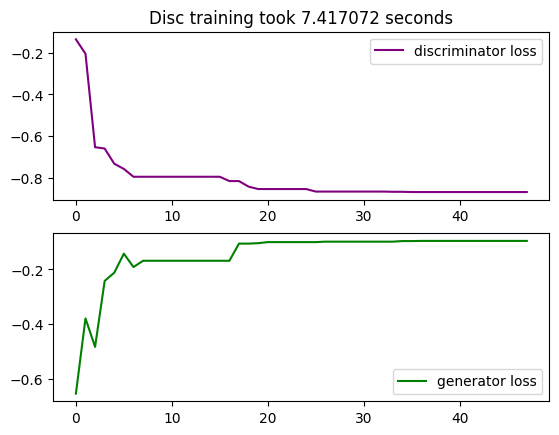

In [8]:
qc = real_disc_circuit(phi, theta, omega, disc_weights)
track_loss = []
track_counter_loss = []

start_time = time.time()
disc_weights = manual_optimizer_disc(iterations, sub_steps, qc, disc_weights, gen_weights, track_loss)
end_time = time.time()

elapsed_time = end_time - start_time


#visualize
plt.subplot(2,1,1)
plt.title(f"Disc training took {elapsed_time:.6f} seconds")
plt.plot(np.arange(0, len(track_loss), 1), track_loss, color='purple', label='discriminator loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, len(track_loss), 1), track_counter_loss, color='green', label='generator loss')
plt.legend()

### TRAIN GENERATOR ONLY

Function took 5.413922 seconds to complete.


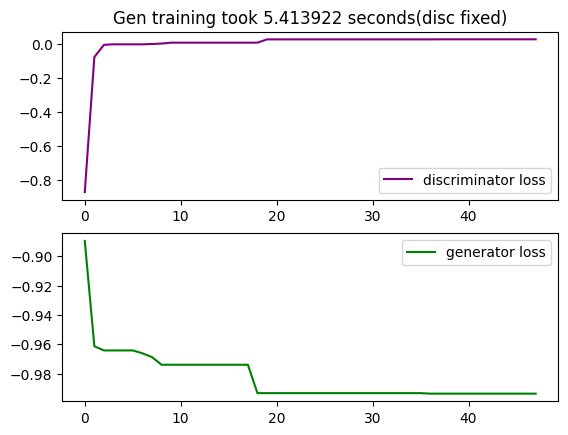

In [9]:
qc = gen_disc_circuit(disc_weights)
track_loss_gen = []
track_counter_loss = []

start_time = time.time()
gen_weights = manual_optimizer_gen(iterations, sub_steps, qc, disc_weights, gen_weights, track_loss_gen)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Function took {elapsed_time:.6f} seconds to complete.")

plt.subplot(2,1,1)
plt.title(f"Gen training took {elapsed_time:.6f} seconds(disc fixed)")
plt.plot(np.arange(0, len(track_loss), 1), track_counter_loss, color='purple', label='discriminator loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, len(track_loss), 1), track_loss_gen, color='green', label='generator loss')
plt.legend()

## Final Costs

### we expect discriminator cost to be around 0, since after generator training discriminator shouldn't be able to discriminate between real and generated

In [10]:
dc = disc_cost(gen_weights, disc_weights)
gc = gen_cost(gen_weights, disc_weights)

print(f"Final Discriminator Cost= {dc:.6f}")
print(f"Final Generator Cost= {gc:.6f}")

Final Discriminator Cost= 0.027828
Final Generator Cost= -0.993635


## Bloch Sphere Representation of Real Circuit and Trained Generator Circuit

both should be approximately be the same

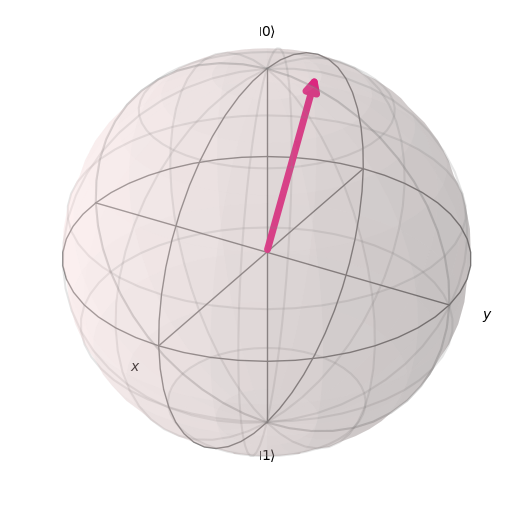

In [11]:
qc = real_disc_circuit(phi, theta, omega, disc_weights)
qc = qc.assign_parameters(disc_weights)
s = statevector_qubit(qc, 0)
plot_bloch_vector(s)

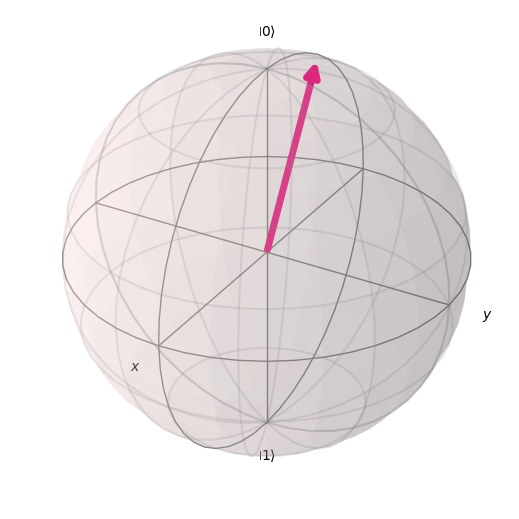

In [12]:
qc = gen_disc_circuit(disc_weights)
qc = qc.assign_parameters(gen_weights)
s = statevector_qubit(qc, 0)
plot_bloch_vector(s)